In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [39]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Using the CPU


In [0]:
loss_L2 = torch.nn.MSELoss()
def train_it(dataset, model, disc,Npast=1, Nfuture=1):
    #model = model
    learning_rate = 1e-4
    optim_model = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optim_disc  = torch.optim.Adam(disc.parameters(), lr=learning_rate)

    Nepoch = 1000
    Nbatch = 50
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        
        # Step the discriminator
        y_pred = model(xx)+xx
        L_D = -0.5*(1 - disc(y_pred).mean() + disc(yy).mean())
        optim_disc.zero_grad()
        L_D.backward(retain_graph=True)
        optim_disc.step()
        
        # Step the model
        L_G = 0.5*(1 - disc(y_pred).mean())
        optim_model.zero_grad()
        L_G.backward()
        optim_model.step()
        
        #yy[:,:,1:-1]
        L2 = loss_L2(y_pred,yy)
        if e%Nprint == Nprint-1:
            print(e, L_D.item(),L2.item())
        if e%Nsave == Nsave-1:
            losses[e//Nsave,0] = L_D.item()
            losses[e//Nsave,1] = L2.item()
    return losses

In [0]:
import importlib
import util
importlib.reload(util)
from util import *

In [0]:
stash = {}


In [169]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in [("PureStencil",PureStencil)]: #models.items():
        try:
            model =  stash[name]['model']
            disc =   stash[name]['disc']
            results =stash[name]['loss'] 
            print("Resuming training of ",name)
        except KeyError:
            model = cls(Nx).to(device)
            disc = DiscriminatorConv(Nx,1).to(device)
            results = np.empty((0,2))
            print("Training new ",name)
        tr_res = train_it(dataset,model,disc)
        results = np.append(results, tr_res, axis=0)
        stash[name] = {'model':model,
                       'disc':disc,
                       'loss':results}

Training new  PureStencil
939 -0.5019582509994507 0.20553439855575562
1879 -0.5000587701797485 0.001889093779027462
2819 -0.4989132285118103 0.04501032456755638
3759 -0.500287652015686 0.03998292610049248
4699 -0.5003535747528076 0.006164653226733208
5639 -0.4996723532676697 0.02262679673731327
6579 -0.49998345971107483 0.0015450348146259785
7519 -0.5000263452529907 0.015324695967137814
8459 -0.4997495114803314 0.005893030669540167
9399 -0.5000267028808594 0.0013523583766072989


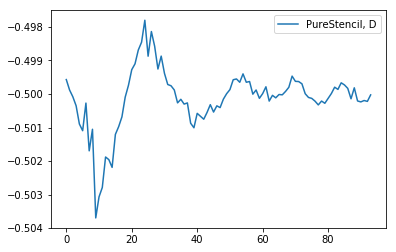

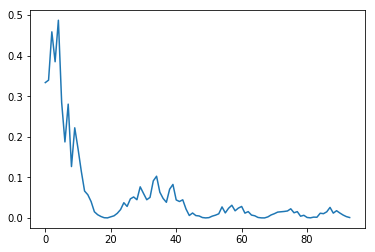

In [170]:
for N,S in stash.items():
    plt.plot(S['loss'][:,0],label=f"{N}, D")
    #plt.plot(S['loss'][:,1],label=f"{N}, G")
#plt.ylim(0.49,0.51)
plt.legend()
plt.show()
for N,S in stash.items():
    plt.plot(S['loss'][:,1],label=f"{N}, L2")
plt.show()

PureStencil


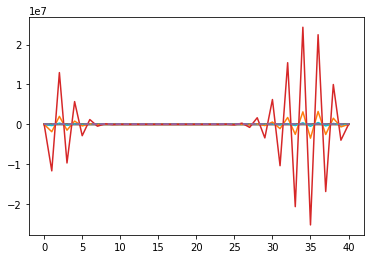

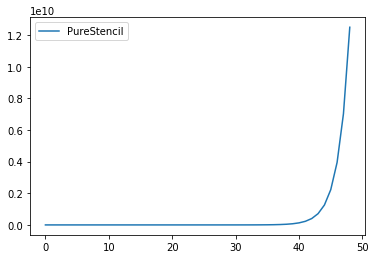

In [171]:
err = {}
for N,S in stash.items():
    print(N)
    err[N] = do_a_path(S['model'],dataset,4)
for N,e in err.items():
    plt.plot(e,label=N)
plt.legend()
plt.show()

In [172]:
list(model.parameters())

[Parameter containing:
 tensor([[[-0.1090,  0.3144, -0.2467]]], requires_grad=True)]